### This example demonstrates the use of experience replay with XCSF
Uses the cart-pole problem from the [OpenAI Gym](https://gym.openai.com).

In [1]:
from __future__ import annotations

import random
from collections import deque
from typing import Final

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from matplotlib import animation, rcParams
from tqdm import tqdm

import xcsf

### Initialise OpenAI Gym problem environment

In [2]:
env = gym.make("CartPole-v0")
X_DIM: Final[int] = env.observation_space.shape[0]
N_ACTIONS: Final[int] = env.action_space.n

### Initialise XCSF

In [3]:
# constructor = (x_dim, y_dim, n_actions)
xcs: xcsf.XCS = xcsf.XCS(X_DIM, N_ACTIONS, 1)  # Supervised: i.e, single action

xcs.OMP_NUM_THREADS = 8  # number of CPU cores to use
xcs.POP_INIT = False  # use covering to initialise
xcs.MAX_TRIALS = 1  # one trial per fit
xcs.POP_SIZE = 200  # maximum population size
xcs.E0 = 0.001  # target error
xcs.BETA = 0.05  # classifier parameter update rate
xcs.ALPHA = 1  # accuracy offset
xcs.NU = 5  # accuracy slope
xcs.EA_SUBSUMPTION = False
xcs.SET_SUBSUMPTION = False
xcs.THETA_EA = 100  # EA invocation frequency
xcs.THETA_DEL = 100  # min experience before fitness used for deletion

condition_layers: Final[dict] = {
    "layer_0": {  # hidden layer
        "type": "connected",
        "activation": "selu",
        "evolve_weights": True,
        "evolve_neurons": True,
        "n_init": 1,
        "n_max": 100,
        "max_neuron_grow": 1,
    },
    "layer_1": {  # output layer
        "type": "connected",
        "activation": "linear",
        "evolve_weights": True,
        "n_init": 1,
    },
}

xcs.condition("neural", condition_layers)  # neural network conditions
xcs.action("integer")  # (dummy) integer actions
xcs.prediction("rls_quadratic")  # Quadratic RLS

GAMMA: Final[float] = 0.95  # discount rate for delayed reward
epsilon: float = 1  # initial probability of exploring
EPSILON_MIN: Final[float] = 0.1  # the minimum exploration rate
EPSILON_DECAY: Final[float] = 0.98  # the decay of exploration after each batch replay
REPLAY_TIME: Final[int] = 1  # perform replay update every n episodes

print(xcs.json_parameters())

{
	"version":	"1.2.1",
	"x_dim":	4,
	"y_dim":	2,
	"n_actions":	1,
	"omp_num_threads":	8,
	"pop_init":	false,
	"max_trials":	1,
	"perf_trials":	1000,
	"pop_size":	200,
	"loss_func":	"mae",
	"set_subsumption":	false,
	"theta_sub":	100,
	"e0":	0.001,
	"alpha":	1,
	"nu":	5,
	"beta":	0.05,
	"delta":	0.1,
	"theta_del":	100,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	100,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	false,
		"pred_reset":	false
	},
	"condition":	{
		"type":	"neural",
		"args":	{
			"layer_0":	{
				"type":	"connected",
				"activation":	"selu",
				"n_inputs":	4,
				"n_init":	1,
				"evolve_weights":	true,
				"evolve_functions":	false,
				"evolve_connect":	false,
				"evolve_neurons":	true,
				"n_max":	100,
				"max_neuron_grow":	1,
				"sgd_weights":	false
			},
			"layer_1":	{
				"type":	"connected",
				"activ

### Execute experiment

In [4]:
total_steps: int = 0  # total number of steps performed
MAX_EPISODES: Final[int] = 2000  # maximum number of episodes to run
N: Final[int] = 100  # number of episodes to average performance
memory: deque[tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=50000)
scores: deque[float] = deque(maxlen=N)  # used to calculate moving average

# for rendering an episode as a gif
SAVE_GIF: Final[bool] = True
SAVE_GIF_EPISODES: Final[int] = 50

frames: list[list[float]] = []
fscore: list[float] = []
ftrial: list[int] = []


def replay(replay_size: int = 5000) -> None:
    """Performs experience replay updates"""
    batch_size: Final[int] = min(len(memory), replay_size)
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        y_target = reward
        if not done:
            prediction_array = xcs.predict(next_state.reshape(1, -1))[0]
            y_target += GAMMA * np.max(prediction_array)
        target = xcs.predict(state.reshape(1, -1))[0]
        target[action] = y_target
        xcs.fit(state.reshape(1, -1), target.reshape(1, -1), True)


def egreedy_action(state: np.ndarray) -> int:
    """Selects an action using an epsilon greedy policy"""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS)
    prediction_array = xcs.predict(state.reshape(1, -1))[0]
    # break ties randomly
    best_actions = np.where(prediction_array == prediction_array.max())[0]
    return int(np.random.choice(best_actions))


def episode(episode_nr: int, create_gif: bool) -> tuple[float, int]:
    """Executes a single episode, saving to memory buffer"""
    episode_score: int = 0
    episode_steps: int = 0
    state: np.ndarray = env.reset()
    while True:
        action = egreedy_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_steps += 1
        episode_score += reward
        memory.append((state, action, reward, next_state, done))
        if create_gif:
            frames.append(env.render(mode="rgb_array"))
            fscore.append(episode_score)
            ftrial.append(episode_nr)
        if done:
            if create_gif:
                for _ in range(100):
                    frames.append(frames[-1])
                    fscore.append(fscore[-1])
                    ftrial.append(ftrial[-1])
            break
        state = next_state
    return episode_score, episode_steps


# learning episodes
for ep in range(MAX_EPISODES):
    gif: bool = False
    if SAVE_GIF and ep % SAVE_GIF_EPISODES == 0:
        gif = True
    # execute a single episode
    ep_score, ep_steps = episode(ep, gif)
    # perform experience replay updates
    if ep % REPLAY_TIME == 0:
        replay()
    # display performance
    total_steps += ep_steps
    scores.append(ep_score)
    mean_score = np.mean(scores)
    print(
        f"episodes={ep} "
        f"steps={total_steps} "
        f"score={mean_score:.2f} "
        f"epsilon={epsilon:.5f} "
        f"error={xcs.error():.5f} "
        f"msize={xcs.mset_size():.2f}"
    )
    # is the problem solved?
    if ep > N and mean_score > env.spec.reward_threshold:
        print(
            f"solved after {ep} episodes: "
            f"mean score {mean_score:.2f} > {env.spec.reward_threshold:.2f}"
        )
        break
    # decay the exploration rate
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY

episodes=0 steps=31 score=31.00 epsilon=1.00000 error=0.46138 msize=0.99
episodes=1 steps=94 score=47.00 epsilon=0.98000 error=0.48311 msize=2.96
episodes=2 steps=112 score=37.33 epsilon=0.96040 error=0.48036 msize=4.99
episodes=3 steps=129 score=32.25 epsilon=0.94119 error=0.44380 msize=7.00
episodes=4 steps=145 score=29.00 epsilon=0.92237 error=0.56284 msize=10.61
episodes=5 steps=197 score=32.83 epsilon=0.90392 error=0.46016 msize=14.42
episodes=6 steps=225 score=32.14 epsilon=0.88584 error=0.38925 msize=18.99
episodes=7 steps=237 score=29.62 epsilon=0.86813 error=0.35919 msize=23.00
episodes=8 steps=273 score=30.33 epsilon=0.85076 error=0.37160 msize=29.00
episodes=9 steps=292 score=29.20 epsilon=0.83375 error=0.33689 msize=34.99
episodes=10 steps=314 score=28.55 epsilon=0.81707 error=0.29372 msize=41.00
episodes=11 steps=324 score=27.00 epsilon=0.80073 error=0.33125 msize=47.00
episodes=12 steps=343 score=26.38 epsilon=0.78472 error=0.31264 msize=54.83
episodes=13 steps=362 score=

episodes=106 steps=12327 score=121.02 epsilon=0.11748 error=0.09762 msize=200.00
episodes=107 steps=12487 score=122.50 epsilon=0.11513 error=0.10901 msize=200.00
episodes=108 steps=12648 score=123.75 epsilon=0.11283 error=0.25402 msize=200.00
episodes=109 steps=12800 score=125.08 epsilon=0.11057 error=0.62849 msize=200.00
episodes=110 steps=12887 score=125.73 epsilon=0.10836 error=0.16124 msize=200.00
episodes=111 steps=13064 score=127.40 epsilon=0.10619 error=0.12663 msize=200.00
episodes=112 steps=13184 score=128.41 epsilon=0.10407 error=0.50539 msize=200.00
episodes=113 steps=13318 score=129.56 epsilon=0.10199 error=0.10450 msize=200.00
episodes=114 steps=13447 score=130.54 epsilon=0.09995 error=0.12767 msize=200.00
episodes=115 steps=13571 score=131.32 epsilon=0.09995 error=0.18521 msize=200.00
episodes=116 steps=13719 score=132.59 epsilon=0.09995 error=0.13836 msize=200.00
episodes=117 steps=13828 score=133.45 epsilon=0.09995 error=0.49873 msize=200.00
episodes=118 steps=14017 sco

episodes=208 steps=30723 score=180.75 epsilon=0.09995 error=0.28721 msize=147.12
episodes=209 steps=30923 score=181.23 epsilon=0.09995 error=0.30181 msize=189.51
episodes=210 steps=31123 score=182.36 epsilon=0.09995 error=0.16495 msize=164.51
episodes=211 steps=31323 score=182.59 epsilon=0.09995 error=0.11134 msize=158.29
episodes=212 steps=31523 score=183.39 epsilon=0.09995 error=0.06929 msize=180.98
episodes=213 steps=31723 score=184.05 epsilon=0.09995 error=0.05989 msize=182.52
episodes=214 steps=31923 score=184.76 epsilon=0.09995 error=0.04938 msize=182.26
episodes=215 steps=32123 score=185.52 epsilon=0.09995 error=0.10410 msize=182.61
episodes=216 steps=32323 score=186.04 epsilon=0.09995 error=0.04948 msize=172.11
episodes=217 steps=32523 score=186.95 epsilon=0.09995 error=0.10327 msize=176.72
episodes=218 steps=32723 score=187.06 epsilon=0.09995 error=0.09012 msize=187.98
episodes=219 steps=32923 score=187.61 epsilon=0.09995 error=0.06278 msize=174.68
episodes=220 steps=33123 sco

### Final exploit episode

In [5]:
epsilon = 0
ep_score, ep_steps = episode(ep, SAVE_GIF)
print(f"score = {ep_score}, steps = {ep_steps}")

score = 200.0, steps = 200


### Render the learning episodes

In [6]:
def save_frames_as_gif(path: str = "./", filename: str = "animation.gif") -> None:
    """Save animation as gif."""
    rcParams["font.family"] = "monospace"
    fig = plt.figure(dpi=90)
    fig.set_size_inches(3, 3)
    ax = fig.add_subplot(111)
    patch = plt.imshow(frames[0])
    bbox = dict(boxstyle="round", fc="0.8")
    plt.axis("off")

    bar = tqdm(total=len(frames), position=0, leave=True)  # progress bar

    def animate(i: int) -> None:
        patch.set_data(frames[i])
        strial = str(ftrial[i])
        sscore = str(int(fscore[i]))
        text = f"episode = {strial:3s}, score = {sscore:3s}"
        ax.annotate(text, xy=(0, 100), xytext=(-40, 1), fontsize=12, bbox=bbox)
        bar.refresh()
        bar.update(1)

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames=len(frames), interval=100, blit=False
    )
    anim.save(path + filename, writer="imagemagick", fps=30)

    bar.close()

Creating gif. This may take a while...


1564it [1:03:57,  2.45s/it]                                                                                                                                                                                


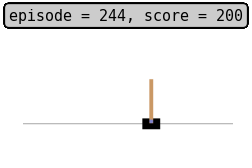

In [7]:
if SAVE_GIF:
    print("Creating gif. This may take a while...")
    save_frames_as_gif()

In [8]:
!gifsicle -O3 --colors=64 --use-col=web --lossy=100 --crop 0,10-270,220 --output out.gif animation.gif

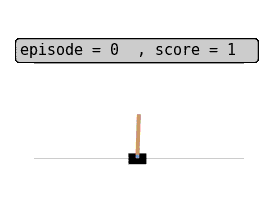

In [9]:
if SAVE_GIF:
    display(Image(open("out.gif", "rb").read()))

In [10]:
env.close()  # close Gym